In [6]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="anthropic.claude-3-5-sonnet-20240620-v1:0",
    model_kwargs=dict(temperature=0, max_tokens=8192),
    credentials_profile_name="default",
    region_name="region_name"
)


In [7]:
llm.invoke("Hello, world!")

AIMessage(content="Hello! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything.", additional_kwargs={'usage': {'prompt_tokens': 11, 'completion_tokens': 37, 'total_tokens': 48}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 11, 'completion_tokens': 37, 'total_tokens': 48}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-1e637fab-5e8b-4f69-9857-9dcb349a52dc-0', usage_metadata={'input_tokens': 11, 'output_tokens': 37, 'total_tokens': 48})

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_teddynote.graphs import visualize_graph


# 주식 리포터의 속성과 메타데이터를 정의하는 클래스
class KDBanalyst(BaseModel):
    # 주요 소속 정보 
    affiliation: str = Field(
        description="리포터의 소속 회사",
        default=""
    )
    # 이름
    name: str = Field(
        description="리포터의 이름",
        default="김재현"
    )
    # 전문 분야
    expertise: str = Field(
        description="주식 시장 전문 분야",
        default="나스닥 개인투자자"
    )
    # 분석 관점
    analysis_focus: str = Field(
        description="주식 분석의 주요 관점",
        default="기술적 분석, 펀더멘털 분석, 시장 동향 분석"
    )
    # 투자 스타일
    investment_style: str = Field(
        description="투자 스타일과 전략",
        default="단기 투자 및 스켈핑 유저"
    )
    # 리스크 관리 방식
    risk_management: str = Field(
        description="리스크 관리 방식",
        default="포트폴리오 분산, 손절매 규칙 준수"
    )

    # 리포터의 정보를 문자열로 반환하는 속성
    @property
    def profile(self) -> str:
        return f"""
        📊 Stock Reporter Profile 📊
        소속: {self.affiliation}
        이름: {self.name}
        전문분야: {self.expertise}
        분석관점: {self.analysis_focus}
        투자스타일: {self.investment_style}
        리스크관리: {self.risk_management}
        """
    
    @property
    def description(self) -> str:
        return f"""
        전문분야: {self.expertise}
        분석관점: {self.analysis_focus}
        투자스타일: {self.investment_style}
        리스크관리: {self.risk_management}
        """


# 리포트 생성을 위한 클래스
class Perspectives(BaseModel):
    # 리포터 정보
    reporters: List[KDBanalyst] = Field(
        description="리포트 작성에 참여한 리포터 목록",
    )




In [9]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 사람 피드백
    human_analyst_feedback: str
    # 분석가 목록
    analysts: List[KDBanalyst]



In [10]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# 분석가 생성 프롬프트 
analyst_instructions = """주식 분석가 페르소나 생성을 담당하게 됩니다.

다음 지침을 주의 깊게 따라주세요:
1. 먼저 연구 주제를 검토하세요:

{topic}

2. 분석가 생성을 안내하기 위해 제공된 편집 피드백을 검토하세요:

{human_analyst_feedback}

3. 위의 문서 및/또는 피드백을 바탕으로 주식 분석에 필요한 주요 관점을 파악하세요.

4. 상위 {max_analysts}개의 관점을 선택하세요.

5. 각 관점별로 다음 속성을 가진 분석가를 생성하세요:
   - 소속: 4대은행(국민, 신한, 우리, 하나) 별 투자증권회사 및 금융기관
   - 이름: 한국식 이름
   - 전문분야: 주식시장 특정 분야
   - 분석관점: 기술적/펀더멘털/시장동향 분석 중 선택
   - 투자스타일: 단기/중기/장기 투자 전략
   - 리스크관리: 구체적인 리스크 관리 방식"""

# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성하는 함수"""
    
    topic = state["topic"]
    max_analysts = state["max_analysts"] 
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # LLM에 구조화된 출력 형식을 적용
    structured_llm = llm.with_structured_output(Perspectives)

    # 분석가 생성을 위한 시스템 프롬프트 구성
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # LLM을 호출하여 분석가 페르소나 생성
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="KDBanalyst 클래스 형식에 맞는 분석가 집합을 생성하세요.")]
    )

    # 생성된 분석가 목록을 상태에 저장
    return {"analysts": analysts.reporters}

# 사용자 피드백 노드
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass

# 인간 피드백 여부에 따라 워크플로우의 다음 단계를 결정하는 함수 
def should_continue(state: GenerateAnalystsState):
    """워크플로우의 다음 단계를 결정하는 함수"""
    
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
        
    return END



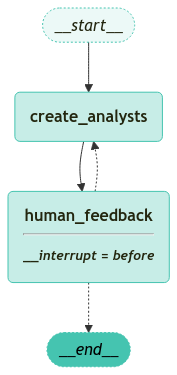

In [11]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

# 그래프 생성
builder = StateGraph(GenerateAnalystsState)

# 노드 추가
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# 엣지 연결
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# 조건부 엣지 추가: 사람 피드백이 있을 경우 다시 분석가 생성 노드로 돌아갑니다.
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# 메모리 생성
memory = MemorySaver()

# 그래프 컴파일(중단점 설정)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# 그래프 시각화
visualize_graph(graph)



In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# 분석가 수 설정
max_analysts = 3

# 연구 주제 설정
topic = "12월 03일 윤석열 대통령의 계염사태와 주식시장의 영향 떨어진 코스피는 복구 불가능할까?"

# 입력 데이터 설정
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='국민투자증권' name='김태훈' expertise='정치경제 분석' analysis_focus='펀더멘털 분석' investment_style='중장기 투자' risk_management='정치적 리스크 헤지 전략 수립'
affiliation='신한금융투자' name='이수진' expertise='기술주 분석' analysis_focus='기술적 분석' investment_style='단기 투자 및 스윙 트레이딩' risk_management='변동성 기반 포지션 조절'
affiliation='우리투자증권' name='박준호' expertise='거시경제 분석' analysis_focus='시장 동향 분석' investment_style='장기 가치 투자' risk_management='섹터 분산 투자 및 정기적 리밸런싱'

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [13]:
# 그래프의 현재 상태 가져오기
state = graph.get_state(config)

# 다음 실행할 노드 확인
print(state.next)

('human_feedback',)


In [14]:
# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config,
    {
        "human_analyst_feedback": "주식 투자 경험이 풍부한 전문 트레이더 김재현을 추가하여 기술적 분석 관점을 더해주세요"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': 'ec1508c3-6e09-4240-897d-1af203cbc9b2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc5ca8-fd9a-6772-8002-79ead47a2a9a'}}

In [15]:
# 이어서 진행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='국민투자증권' name='김재현' expertise='기술주 및 IT 섹터' analysis_focus='기술적 분석' investment_style='단기 투자 및 스윙 트레이딩' risk_management='철저한 손절매 규칙 및 포지션 사이징'
affiliation='신한금융투자' name='이수진' expertise='거시경제 및 정책 분석' analysis_focus='펀더멘털 분석' investment_style='중장기 가치 투자' risk_management='섹터 분산 및 헤지 전략 활용'
affiliation='우리투자증권' name='박민우' expertise='정치경제 및 산업 동향' analysis_focus='시장 동향 분석' investment_style='이벤트 드리븐 투자' risk_management='시나리오 분석 및 옵션 전략'

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [16]:
# 추가 피드백이 없을 경우 None 값을 할당하여 상태 업데이트
human_feedback_input = None

# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)

{'configurable': {'thread_id': 'ec1508c3-6e09-4240-897d-1af203cbc9b2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc5ca9-42df-6a08-8004-bc39adf3a33b'}}

In [17]:
# 이어서 진행
invoke_graph(graph, None, config)

In [18]:
# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 상태에서 생성된 분석가 목록 가져오기
analysts = final_state.values.get("analysts")

# 생성된 분석가 수 출력
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

# 각 분석가의 페르소나 출력
for analyst in analysts:
    print(analyst.profile)
    print("- " * 30)


생성된 분석가 수: 3

        📊 Stock Reporter Profile 📊
        소속: 국민투자증권
        이름: 김재현
        전문분야: 기술주 및 IT 섹터
        분석관점: 기술적 분석
        투자스타일: 단기 투자 및 스윙 트레이딩
        리스크관리: 철저한 손절매 규칙 및 포지션 사이징
        
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

        📊 Stock Reporter Profile 📊
        소속: 신한금융투자
        이름: 이수진
        전문분야: 거시경제 및 정책 분석
        분석관점: 펀더멘털 분석
        투자스타일: 중장기 가치 투자
        리스크관리: 섹터 분산 및 헤지 전략 활용
        
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

        📊 Stock Reporter Profile 📊
        소속: 우리투자증권
        이름: 박민우
        전문분야: 정치경제 및 산업 동향
        분석관점: 시장 동향 분석
        투자스타일: 이벤트 드리븐 투자
        리스크관리: 시나리오 분석 및 옵션 전략
        
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


# 질문생성

In [19]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


# 인터뷰 상태 정의
class InterviewState(MessagesState):
    # 대화 턴수
    max_num_turns: int
    # 소스 문서를 포함하는 컨텍스트 리스트
    context: Annotated[list, operator.add]
    # 지정된 분석가
    analyst: KDBanalyst
    # 인터뷰 내용을 저장하는 문자열
    interview: str
    # 보고서 섹션 리스트
    sections: list


# 검색 쿼리 데이터 클래스 정의
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


In [20]:
question_instructions = """당신은 Human-in-the-loop 방식으로 전문가와 협업하는 분석가입니다.

당신의 목표는 전문가와의 상호작용을 통해 더 나은 결과물을 도출하는 것입니다.

1. 협업: 전문가의 도메인 지식을 최대한 활용하여 함께 문제를 해결

2. 반복: 전문가의 피드백을 받아 지속적으로 개선

3. 구체화: 추상적인 아이디어를 구체적인 해결책으로 발전

다음은 당신이 집중해야 할 주제와 목표입니다: {goals}

먼저 당신의 페르소나에 맞는 이름으로 자신을 소개하고, 협업의 목적을 설명하세요.

전문가의 의견을 경청하고 이해한 내용을 바탕으로 구체적인 질문을 이어가세요.

충분한 협업이 이루어졌다고 판단되면 "협업해 주셔서 감사합니다!"라고 마무리하세요.

전체 과정에서 Human-in-the-loop 철학에 맞는 협업적이고 반복적인 접근을 유지하세요."""


# 질문을 생성하는 노드 정의
def generate_question(state: InterviewState):
    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]

    # 질문 생성
    # 분석가의 목표를 기반으로 시스템 메시지 생성
    system_message = question_instructions.format(goals=analyst.profile)
    # LLM을 사용하여 질문 생성
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 상태에 메시지 기록
    return {"messages": [question]}

# 도구 정의

In [21]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.tools import YouTubeSearchTool

from youtube_transcript_api import YouTubeTranscriptApi
import ast
# 유튜브 검색 도구 초기화
youtube_search_tool = YouTubeSearchTool()


# 웹 검색을 위한 TavilySearch 인스턴스 생성
tavily_search = TavilySearch(max_results=3)

In [22]:
youtube_search_tool = YouTubeSearchTool()
youtube_results = youtube_search_tool.run("윤석열 계엄령")

# 노드 생성

In [23]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_community.tools import YouTubeSearchTool
from youtube_transcript_api import YouTubeTranscriptApi
import ast

# 검색 쿼리 작성
search_instructions = SystemMessage(
    content=f"""분석가와 전문가 사이의 대화가 주어질 것입니다.

당신의 목표는 대화와 관련된 검색 및 웹 검색에 사용할 잘 구조화된 쿼리를 생성하는 것입니다.

먼저 전체 대화를 분석하세요.

특히 분석가가 마지막으로 제기한 질문에 주목하세요.

이 마지막 질문을 잘 구조화된 웹 검색 쿼리로 변환하세요."""
)


# 웹 검색 수행 함수 정의
def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""
    
    # 검색 쿼리 생성
    tavily_search = TavilySearch(max_results=3)
    structured_llm = llm.with_structured_output(SearchQuery)
    
    # 메시지 형식 맞추기 
    messages = state["messages"]
    search_query = structured_llm.invoke([
        SystemMessage(content="\n\nHuman: 검색 쿼리를 생성해주세요.\n\nAssistant:"),
        HumanMessage(content=f"\n\nHuman: {messages}\n\nAssistant:")
    ])

    # 검색 수행
    search_docs = tavily_search.invoke(search_query.search_query)

    # 검색 결과 형식 지정
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# YouTube 검색 노드 생성
def search_youtube(state: InterviewState):
    """YouTube 검색 노드"""
    
    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    
    # 마지막 메시지가 HumanMessage인지 확인하고 필터링
    messages = state["messages"]
    filtered_messages = []
    for msg in messages:
        if isinstance(msg, AIMessage) and msg == messages[-1]:
            continue
        filtered_messages.append(msg)
        
    # 프롬프트 형식 맞추기
    search_query = structured_llm.invoke([
        SystemMessage(content="\n\nHuman: 검색 쿼리를 생성해주세요.\n\nAssistant: 네, 검색 쿼리를 생성하겠습니다."),
        HumanMessage(content=f"\n\nHuman: {filtered_messages}\n\nAssistant:")
    ])

    print("youtube search query: ", search_query.search_query)

    def get_video_info(url):
        """유튜브 URL에서 동영상 ID를 추출하고 자막을 가져오는 함수"""
        try:
            video_id = url.split('watch?v=')[1].split('&')[0]
            transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['ko', 'en'])
            text = "\n".join([item['text'] for item in transcript])
            return {
                'video_id': video_id,
                'url': url,
                'transcript': text
            }
        except Exception as e:
            print(f"동영상 처리 중 오류 발생: {str(e)}")
            return None

    try:
        # YouTube 검색 수행
        youtube_search_tool = YouTubeSearchTool()
        youtube_results = ast.literal_eval(youtube_search_tool.run(search_query.search_query))
        
        # 각 동영상의 정보와 자막 가져오기
        formatted_results = []
        for url in youtube_results:
            if isinstance(url, str) and 'youtube.com' in url:
                video_info = get_video_info(url)
                if video_info:
                    formatted_results.append(
                        f'<Document source="youtube" url="{video_info["url"]}">\n'
                        f'<Content>\n{video_info["transcript"][:1000]}...\n</Content>\n'
                        f'</Document>'
                    )

        formatted_search_docs = "\n\n---\n\n".join(formatted_results)
        return {"context": [formatted_search_docs]}
        
    except Exception as e:
        print(f"YouTube 검색 중 오류 발생: {str(e)}")
        return {
            "context": ["<Error>YouTube 검색 결과를 가져오는데 실패했습니다.</Error>"]
        }


answer_instructions = """당신은 분석가와 인터뷰를 하는 전문가입니다.

분석가의 관심 분야는 다음과 같습니다: {goals}

당신의 목표는 인터뷰어가 제기한 질문에 답변하는 것입니다.

질문에 답변하기 위해 다음 컨텍스트를 사용하세요:

{context}

답변 시 다음 지침을 따르세요:

1. 제공된 컨텍스트의 정보만 사용하세요.

2. 컨텍스트에 명시적으로 언급되지 않은 외부 정보나 가정을 도입하지 마세요.

3. 컨텍스트에는 각 개별 문서의 상단에 출처가 포함되어 있습니다.

4. 답변에서 관련 진술 옆에 이러한 출처를 포함하세요. 예를 들어, 출처 1의 경우 [1]을 사용하세요.

5. 답변 하단에 출처를 순서대로 나열하세요. [1] 출처 1, [2] 출처 2 등

6. 출처가 '<Document source="assistant/docs/llama3_1.pdf" page="7"/>'인 경우:

[1] assistant/docs/llama3_1.pdf, 페이지 7

형식으로만 표시하고 인용문에서 괄호와 Document source 서문을 생략하세요."""


# 질문에 대한 답변 생성 함수 정의
def generate_answer(state: InterviewState):
    """질문에 대한 답변 생성 노드"""
    
    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    print("@@@@@컨텍스트:", context)

    
    # 컨텍스트가 비어있는 경우 처리
    if not context:
        context = ["검색 결과가 없습니다."]
    
    # 질문에 대한 답변 생성
    system_message = answer_instructions.format(
        goals=analyst.description , 
        context="\n\n".join(context)
    )
    
    try:
        # 답변 생성
        response = llm.invoke([
            SystemMessage(content=system_message),
            HumanMessage(content="\n컨텍스트:\n" + "\n".join(context) + "\n\n질문:\n" + messages[-1].content)
        ])
        
        # AIMessage로 변환하고 전문가 이름 지정
        answer = AIMessage(
            content=response.content,
            name="expert"
        )
        print("@@@@@전문가의 답변:", answer)
        return {"messages": [answer]}
        
    except Exception as e:
        print(f"Error generating answer: {e}")
        return {"messages": [AIMessage(content="답변 생성 중 오류가 발생했습니다.", name="expert")]}


# 인터뷰 저장 함수 정의
def save_interview(state: InterviewState):
    """인터뷰 저장"""

    # 메시지 가져오기
    messages = state["messages"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(messages)

    # 인터뷰 키에 저장
    return {"interview": interview}


# 메시지 라우팅 함수 정의
def route_messages(state: InterviewState, name: str = "expert"):
    """질문과 답변 사이의 라우팅"""

    # 메시지 가져오기
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # 전문가의 답변 수 확인
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 전문가가 최대 턴 수 이상 답변한 경우 종료
    if num_responses >= max_num_turns:
        return "save_interview"

    # 이 라우터는 각 질문-답변 쌍 후에 실행됨
    # 논의 종료를 신호하는 마지막 질문 가져오기
    last_question = messages[-2]

    if "도움 주셔서 감사합니다" in last_question.content:
        return "save_interview"
    return "ask_question"


# 섹션 작성 지시사항
section_writer_instructions = """당신은 전문 기술 작가입니다.

당신의 임무는 소스 문서 세트를 철저히 분석하여 상세하고 포괄적인 보고서 섹션을 작성하는 것입니다.
여기에는 주요 통찰력 추출, 관련 요점 설명, 명확성과 이해를 보장하기 위한 심층적인 설명이 포함됩니다. 글쓰기에는 독자의 이해를 돕기 위한 필요한 맥락, 증거 자료, 예시가 포함되어야 합니다. 논리적이고 잘 구성된 구조를 유지하면서 모든 중요한 측면을 상세히 다루고 전문적인 어조로 제시하세요.

다음 지침을 따르세요:
1. 소스 문서의 내용 분석:
- 각 소스 문서의 이름은 <Document 태그와 함께 문서 시작 부분에 있습니다.

2. 마크다운 형식을 사용하여 보고서 구조 생성:
- ## 섹션 제목에 사용
- ### 하위 섹션 제목에 사용

3. 다음 구조에 따라 보고서 작성:
a. 제목 (## 헤더)
b. 요약 (### 헤더)
c. 종합 분석 (### 헤더)
d. 출처 (### 헤더)

4. 분석가의 관심 분야를 바탕으로 흥미로운 제목 작성:
{focus}

5. 요약 섹션:
- 분석가의 관심 분야와 관련된 일반적인 배경/맥락으로 요약 시작
- 인터뷰에서 얻은 통찰력 중 새롭거나 흥미롭거나 놀라운 점 강조
- 사용하는 소스 문서의 번호 목록 작성
- 인터뷰어나 전문가의 이름 언급 금지
- 최대 400단어를 목표로 작성
- 소스 문서의 정보를 바탕으로 번호가 매겨진 출처 사용 (예: [1], [2])

6. 종합 분석 섹션:
- 소스 문서의 정보에 대한 상세한 검토 제공
- 복잡한 아이디어를 이해하기 쉬운 부분으로 분해하여 논리적 흐름 유지
- 필요한 경우 하위 섹션을 사용하여 여러 관점이나 분석 차원 다루기
- 소스 문서의 데이터, 직접 인용, 예시로 분석 뒷받침
- 각 요점의 전체 보고서 초점과의 관련성 명확히 설명
- 관련된 여러 아이디어 제시 시 명확성을 위해 글머리 기호나 번호 목록 사용
- 편향이나 근거 없는 의견을 피하고 전문적이고 객관적인 어조 유지
- 철저한 분석을 위해 최소 800단어 작성

7. 출처 섹션:
- 보고서에 사용된 모든 출처 포함
- 관련 웹사이트나 특정 문서 경로의 전체 링크 제공
- 각 출처를 줄바꿈으로 구분. 마크다운에서 줄바꿈을 만들기 위해 각 줄 끝에 공백 두 개 사용
- 다음과 같은 형식:

### 출처
[1] 링크 또는 문서 이름
[2] 링크 또는 문서 이름

8. 출처 통합. 예를 들어 다음은 잘못된 예시:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

중복된 출처가 없어야 합니다. 다음과 같이 작성:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. 최종 검토:
- 보고서가 요구된 구조를 따르는지 확인
- 보고서 제목 앞에 서문 포함하지 않기
- 모든 지침이 준수되었는지 확인"""


# 섹션 작성 함수 정의
def write_section(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 컨텍스트, 분석가 가져오기
    context = state["context"]
    analyst = state["analyst"]

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"이 소스를 사용하여 섹션을 작성하세요: {context}")]
    )

    # 상태에 섹션 추가
    return {"sections": [section.content]}


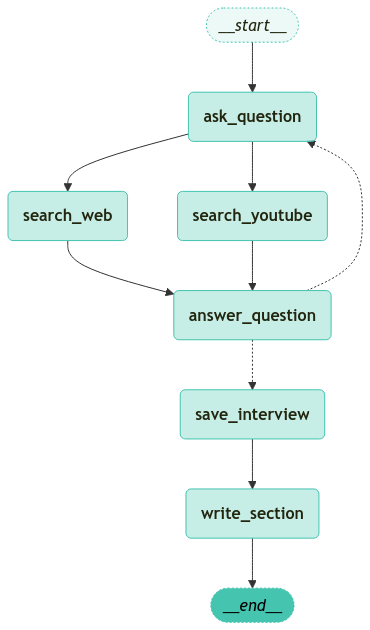

In [24]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 노드 및 엣지 추가
stock_interview_builder = StateGraph(InterviewState)
stock_interview_builder.add_node("ask_question", generate_question)
stock_interview_builder.add_node("search_web", search_web)
stock_interview_builder.add_node("search_youtube", search_youtube)
stock_interview_builder.add_node("answer_question", generate_answer)
stock_interview_builder.add_node("save_interview", save_interview)
stock_interview_builder.add_node("write_section", write_section)

# 흐름 설정
stock_interview_builder.add_edge(START, "ask_question")
stock_interview_builder.add_edge("ask_question", "search_web")
stock_interview_builder.add_edge("ask_question", "search_youtube")
stock_interview_builder.add_edge("search_web", "answer_question")
stock_interview_builder.add_edge("search_youtube", "answer_question")
stock_interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
stock_interview_builder.add_edge("save_interview", "write_section")
stock_interview_builder.add_edge("write_section", END)

# 인터뷰 그래프 생성
memory = MemorySaver()
stock_interview_graph = stock_interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# 그래프 시각화
visualize_graph(stock_interview_graph)


In [25]:
analysts[0]

KDBanalyst(affiliation='국민투자증권', name='김재현', expertise='기술주 및 IT 섹터', analysis_focus='기술적 분석', investment_style='단기 투자 및 스윙 트레이딩', risk_management='철저한 손절매 규칙 및 포지션 사이징')

In [26]:
from IPython.display import Markdown

# 주제 설정
topic = "윤석열 12월 3일 계엄령과 주식시장 미치는 영향"

# 인터뷰 시작 메시지 생성
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# 스레드 ID 설정
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# 그래프 실행
invoke_graph(
    stock_interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 1},
    config,
)



🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 저는 국민투자증권의 김재현 애널리스트입니다. 기술주와 IT 섹터를 전문으로 하며, 기술적 분석을 통한 단기 투자 및 스윙 트레이딩에 중점을 두고 있습니다.

윤석열 대통령의 12월 3일 계엄령 선포 가능성과 그것이 주식시장에 미칠 영향에 대한 기사를 작성하신다고 이해했습니다. 이는 매우 민감하고 중요한 주제입니다. 

이 주제에 대해 몇 가지 확인하고 싶은 사항이 있습니다:

1. 계엄령 선포 가능성에 대한 구체적인 근거나 정보가 있으신가요?
2. 이 소문이 현재 시장에 어떤 영향을 미치고 있다고 보시나요?
3. IT 섹터나 기술주에 특별히 미칠 수 있는 영향이 있을까요?

이러한 정보를 바탕으로 시장의 반응과 대응 전략에 대해 함께 논의할 수 있을 것 같습니다. 어떠신가요?
youtube search query:  윤석열 12월 3일 계엄령 주식시장 영향

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document href="https://contents.premium.naver.com/finup/moneysurferplus/contents/241204180103115tk?from=news_arp_global"/>
윤 대통령, 비상 계엄령 선포와 해제, 국내 시장 영향과 전망 A-Z 모두 정리! 윤 대통령, 비상 계엄령 선포와 해제, 국내 시장 영향과 전망 A-Z 모두 정리! 윤석열 대통령은 3일 밤 10시 23분, 대국민 담화로 비상계엄을 선포했습니다. 4일 새벽 윤석열 대통령은 비상계엄 해제를 선언했습니다. 여당 지도부조차 비상계엄 선포 사실을 인지하고 있지 못했는데요, 국방부는 

In [27]:
analysts[0].description

'\n        전문분야: 기술주 및 IT 섹터\n        분석관점: 기술적 분석\n        투자스타일: 단기 투자 및 스윙 트레이딩\n        리스크관리: 철저한 손절매 규칙 및 포지션 사이징\n        '

In [32]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


# ResearchGraphState 상태 정의
class ResearchGraphState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 인간 분석가의 피드백
    human_analyst_feedback: str
    # 질문을 하는 분석가 목록
    analysts: List[KDBanalyst]
    # Send() API 키를 포함하는 섹션 리스트
    sections: Annotated[list, operator.add]
    # 최종 보고서의 서론
    introduction: str
    # 최종 보고서의 본문 내용
    content: str
    # 최종 보고서의 결론
    conclusion: str
    # 최종 보고서
    final_report: str

In [33]:
from langgraph.constants import Send


# 모든 인터뷰를 시작
def initiate_all_interviews(state: ResearchGraphState):
    # 사람의 피드백 확인
    human_analyst_feedback = state.get("human_analyst_feedback")

    # 만약, 사람의 피드백이 있으면 분석가 생성으로 돌아가기
    if human_analyst_feedback:
        return "create_analysts"

    # 그렇지 않으면 Send() 함수를 통해 인터뷰 병렬로 시작
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]

In [34]:
# 보고서 작성 지시사항
report_writer_instructions = """당신은 다음 주제에 대한 투자 보고서를 작성하는 애널리스트입니다:

{topic}

여러 분석가들이 각각 다음과 같은 작업을 수행했습니다:

1. 해당 분야 전문가와의 인터뷰 진행
2. 분석 내용을 메모로 정리

당신의 임무:

1. 각 분석가들의 메모를 검토합니다.
2. 각 메모의 핵심 내용을 면밀히 분석합니다.
3. 모든 메모의 핵심 아이디어를 통합하여 종합적인 요약을 작성합니다.
4. 각 메모의 주요 포인트를 아래 섹션에 맞게 논리적으로 구성합니다.
5. 모든 필수 섹션을 `### 섹션명` 형식의 헤더로 포함시킵니다.
6. 각 섹션당 약 250자 내외로 심도있는 설명과 근거를 제시합니다.

**보고서 섹션 구성:**

- **시장 환경**: 거시경제 상황, 업종 동향, 핵심 이슈 등 기본적인 배경 설명
- **산업 분석**: 해당 산업의 현황과 전망, 경쟁구도 분석
- **기업 분석**: 대상 기업의 사업구조, 경쟁력, 재무상태 등 분석
- **투자 포인트**: 주요 투자 매력도와 성장 동력 제시
- **리스크 요인**: 주가에 부정적 영향을 미칠 수 있는 위험 요소 분석
- **실적 전망**: 향후 실적 추정과 그 근거 제시
- **투자의견**: 투자등급과 목표주가 제시 및 근거 설명

보고서 형식:

1. 마크다운 형식 사용
2. 서두 없이 바로 본문 시작
3. 소제목 사용하지 않음
4. 보고서는 ## 투자 분석 헤더로 시작
5. 분석가 이름 언급하지 않음
6. 메모의 인용 출처는 [1], [2] 등으로 표시
7. 마지막에 ## 참고자료 섹션에 출처 목록 정리
8. 출처는 순서대로 나열하고 중복 제거

[1] 출처 1
[2] 출처 2

아래는 분석가들의 메모입니다:

{context}"""


# 보고서 작성 함수 정의
def write_report(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 최종 보고서 작성
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"이 메모들을 바탕으로 보고서를 작성해주세요.")]
    )
    return {"content": report.content}


# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """당신은 {topic}에 대한 투자 보고서를 마무리하는 애널리스트입니다.

보고서의 모든 섹션이 주어질 것입니다.

당신의 임무는 간결하고 설득력 있는 서론 또는 결론을 작성하는 것입니다.

사용자가 서론 또는 결론 중 어느 것을 작성할지 지시할 것입니다.

불필요한 서두는 생략합니다.

약 200자 내외로, 서론의 경우 보고서의 모든 섹션을 미리보기하고, 결론의 경우 핵심 내용을 요약합니다.

마크다운 형식을 사용합니다.

서론의 경우 매력적인 제목을 만들고 # 헤더를 사용합니다.

서론은 ## 개요 헤더를 사용합니다.

결론은 ## 결론 헤더를 사용합니다.

참고할 섹션들은 다음과 같습니다: {formatted_str_sections}"""


# 서론 작성 함수 정의
def write_introduction(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 서론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"보고서의 서론을 작성해주세요")]
    )
    return {"introduction": intro.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 결론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"보고서의 결론을 작성해주세요")]
    )
    return {"conclusion": conclusion.content}


# 최종 보고서 작성 함수 정의
def finalize_report(state: ResearchGraphState):
    # 모든 섹션을 모아 최종 보고서 작성
    content = state["content"]
    if content.startswith("## 투자 분석"):
        content = content.strip("## 투자 분석")
    if "## 참고자료" in content:
        try:
            content, sources = content.split("\n## 참고자료\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## 핵심 투자포인트\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## 참고자료\n" + sources
    return {"final_report": final_report}


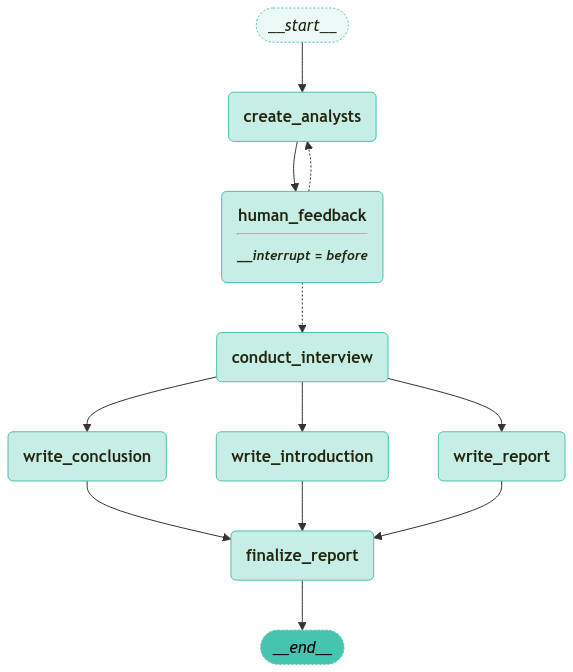

In [36]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langchain_teddynote.graphs import visualize_graph

# 그래프 생성
builder = StateGraph(ResearchGraphState)

# 노드 정의
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", stock_interview_graph)
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 엣지 정의
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# 인터뷰 결과 보고서 작성
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# 보고서 최종 정리
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# 컴파일
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

visualize_graph(graph)


In [37]:
# 입력 데이터 설정
max_analysts = 1
topic = "윤석열 12월 3일 계엄령과 주식시장 미치는 영향"

# config 설정
config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

# 입력 데이터 설정
inputs = {"topic": topic, "max_analysts": max_analysts}

# 그래프 실행: 첫 번째 중단 지점까지
invoke_graph(graph, inputs, config)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='국민투자증권' name='김태훈' expertise='거시경제 및 정치 리스크 분석' analysis_focus='펀더멘털 분석' investment_style='중장기 투자 전략' risk_management='정치적 리스크 헤지 및 분산 투자'

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [38]:
# 새로운 분석가 추가
graph.update_state(
    config,
    {"human_analyst_feedback": "15년 이상 주식 투자 경력이 있는 전문가"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '22777989-5e65-49c4-b2fe-6c8b6700f593',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc5cb5-82ca-6d96-8002-89d9a88ed887'}}

In [39]:
# 그래프 실행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='국민증권' name='김태훈' expertise='정치 경제 분석 및 거시 경제 전문가' analysis_focus='펀더멘털 분석' investment_style='중장기 투자 전략' risk_management='정치적 리스크 헤지 및 분산 투자'
affiliation='신한금융투자' name='이수진' expertise='국내 정치와 주식시장 연관성 분석 전문가' analysis_focus='시장 동향 분석' investment_style='단기 및 중기 투자 전략' risk_management='정치적 이벤트에 따른 포트폴리오 조정'
affiliation='우리투자증권' name='박준호' expertise='안보 이슈와 금융시장 영향 분석 전문가' analysis_focus='기술적 분석' investment_style='단기 투자 및 스윙 트레이딩' risk_management='변동성 지표를 활용한 리스크 관리'
affiliation='하나금융투자' name='정미란' expertise='정치적 불확실성과 주식시장 변동성 연구' analysis_focus='펀더멘털 분석' investment_style='가치 투자 전략' risk_management='섹터 분산 및 안전자산 배분'

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [40]:
# 그래프 재개
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '22777989-5e65-49c4-b2fe-6c8b6700f593',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc5cb7-18e8-6e26-8004-4991e7d49c60'}}

In [41]:
# 그래프 실행
invoke_graph(graph, None, config)


🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 저는 국민증권의 김태훈 애널리스트입니다. 정치 경제 분석 및 거시 경제를 전문으로 하고 있습니다. 윤석열 대통령의 12월 3일 계엄령 선포 가능성과 그것이 주식시장에 미칠 영향에 대해 분석 중이라고 이해했습니다. 이는 매우 중요하고 민감한 주제입니다.

이 주제에 대해 더 자세히 알아보고 싶습니다. 혹시 계엄령 선포 가능성에 대한 구체적인 정보나 근거가 있으신가요? 또한, 이러한 상황이 주식시장에 어떤 영향을 미칠 것으로 예상하시나요? 정치적 불확실성이 증가하면 일반적으로 시장에 부정적인 영향을 미치지만, 구체적인 산업이나 섹터별로 다른 영향이 있을 수 있습니다.

당신의 전문적인 견해를 듣고 싶습니다.

🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 저는 신한금융투자의 주식 애널리스트 김민서입니다. 국내 정치와 주식시장의 연관성을 분석하는 것이 제 전문 분야입니다. 현재 윤석열 대통령의 12월 3일 계엄령 선포 가능성과 그것이 주식시장에 미칠 수 있는 영향에 대한 기사를 준비 중입니다. 

이 주제는 매우 민감하고 복잡한 사안이라고 생각합니다. 정확하고 균형 잡힌 분석을 위해 전문가님의 견해를 듣고 싶습니다. 특히 다음과 같은 점들에 대해 의견을 나누고 싶습니다:

1. 계엄령 선포 가능성에 대한 현실적인 평가
2. 만약 계엄령이 선포된다면 주식시장